# Predict Housing Price -- Regression

In [310]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.preprocessing import Imputer,LabelEncoder,OneHotEncoder,LabelBinarizer,StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.externals import joblib

In [13]:
%matplotlib inline

### Get housing data

In [2]:
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml/master/'
HOUSING_PATH = 'datasets/housing'
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [8]:
fetch_housing_data()
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280,565,259,3.8462,342200,NEAR BAY


###  Explore the data

In [9]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


In [10]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [11]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
dtype: int64

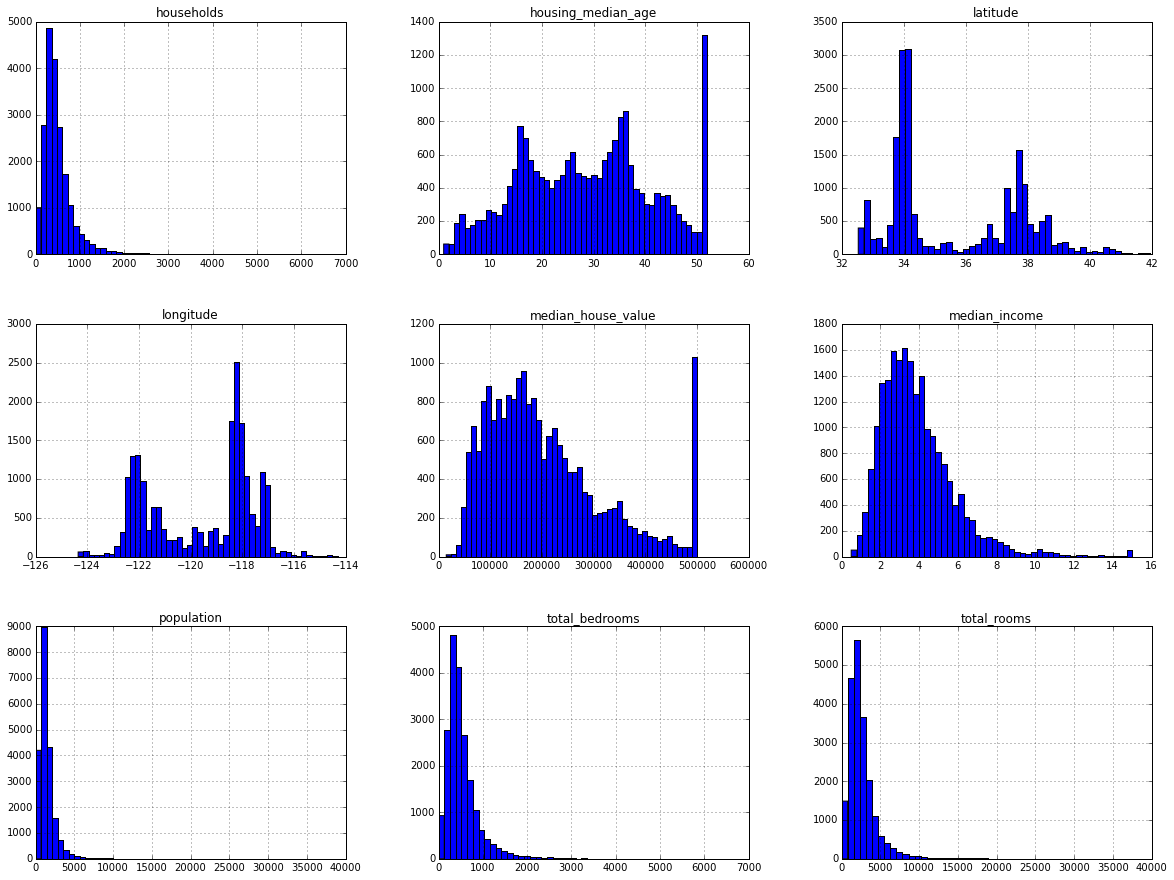

In [15]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

##### split train and test

In [17]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

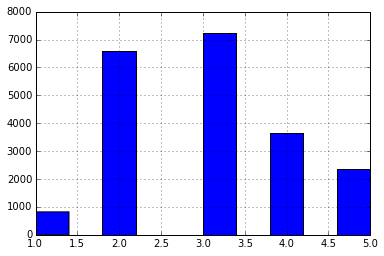

In [26]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
housing["income_cat"].hist()
plt.show()

In [28]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [31]:
housing['income_cat'].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
dtype: float64

In [32]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
dtype: float64

In [33]:
for set in (strat_train_set, strat_test_set):
    set.drop(['income_cat'], axis=1, inplace=True)

##### looking for correlations

In [34]:
corr_matrix = housing.corr()

In [37]:
corr_matrix['median_house_value']

longitude            -0.045967
latitude             -0.144160
housing_median_age    0.105623
total_rooms           0.134153
total_bedrooms        0.049686
population           -0.024650
households            0.065843
median_income         0.688075
median_house_value    1.000000
income_cat            0.643892
Name: median_house_value, dtype: float64

### Experimenting with Attribute Combinations

In [38]:
housing['room_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [39]:
corr_matrix = housing.corr()
corr_matrix['median_house_value']

longitude                  -0.045967
latitude                   -0.144160
housing_median_age          0.105623
total_rooms                 0.134153
total_bedrooms              0.049686
population                 -0.024650
households                  0.065843
median_income               0.688075
median_house_value          1.000000
income_cat                  0.643892
room_per_household          0.151948
bedrooms_per_room          -0.255880
population_per_household   -0.023737
Name: median_house_value, dtype: float64

In [40]:
housing = strat_train_set.drop('median_house_value', axis = 1)
housing_labels = strat_train_set['median_house_value'].copy()

### Data cleaning

In [43]:
imputer = Imputer(strategy='median')
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)
imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [44]:
housing_num.median().values

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [46]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

### Handling Text and Categorical Attributes 

In [48]:
encoder = LabelEncoder()
housing_cat = housing['ocean_proximity']
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [49]:
encoder.classes_

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'], dtype=object)

In [52]:
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
housing_cat_1hot

<16512x5 sparse matrix of type '<type 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [53]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [55]:
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

##### Custom Transformers

In [81]:
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

In [88]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:,rooms_ix] / X[:,household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [89]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

### Feature Scaling

In [90]:
num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler())
    ])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [149]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [261]:
class LabelBinarizerWrapper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.labelBinarizer = LabelBinarizer()
    def fit(self, X, y=None):
        self.labelBinarizer.fit(X)
        return self
    def transform(self, X):
        return self.labelBinarizer.transform(X)

In [262]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler())
    ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', LabelBinarizerWrapper())
    ])
full_pipeline = FeatureUnion(transformer_list=[
        ('num_pipeline', num_pipeline),
        ('cat_pipeline', cat_pipeline)
    ])

In [263]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [264]:
housing_prepared.shape

(16512, 16)

In [265]:
housing.shape

(16512, 9)

### Select and Train a Model

##### Training and Evaluating on the Training Set

In [266]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [268]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print "Predictions:", lin_reg.predict(some_data_prepared)
print "Labels:", list(some_labels)

Predictions: [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849878]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [270]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489234

In [272]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

##### Evaluation Using Cross-Validation

In [281]:
tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                              scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [282]:
tree_rmse_scores

array([ 68287.24451782,  65565.53828295,  69205.37597613,  69378.12902635,
        71774.11622799,  74504.02716796,  69582.73322956,  68964.3263696 ,
        76787.56132104,  69821.76968649])

In [283]:
def display_scores(scores):
    print "Scores:", scores
    print "Mean:", scores.mean()
    print "Standard deviation:", scores.std()

In [284]:
display_scores(tree_rmse_scores)

Scores: [ 68287.24451782  65565.53828295  69205.37597613  69378.12902635
  71774.11622799  74504.02716796  69582.73322956  68964.3263696
  76787.56132104  69821.76968649]
Mean: 70387.0821806
Standard deviation: 3047.96722492


In [286]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, 
                             scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 66782.73843989  66960.118071    70361.0899303   74742.05876932
  68020.26332505  71193.41027241  64969.63056405  68276.39031302
  71543.41013201  67665.10082067]
Mean: 69051.4210638
Standard deviation: 2732.47219243


*The Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model*

In [292]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
forest_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print forest_rmse

0.0


In [293]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                               scoring='neg_mean_squared_error', cv=10)
forest_rmse_score = np.sqrt(-forest_scores)
display_scores(forest_rmse_score)

Scores: [ 52973.46210475  50276.68247071  52385.97570674  55942.95468161
  51275.37691735  56511.8671199   51135.19224618  50896.25610268
  55997.91611864  53311.93408964]
Mean: 53070.7617558
Standard deviation: 2206.82315048


### Fine-Tune Your Model

##### Grid Search

In [295]:
param_grid = [
    {'n_estimators':[3, 10, 30], 'max_features':[2, 4, 6, 8]},
    {'bootstrap':[False], 'n_estimators':[3, 10], 'max_features':[2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'n_estimators': [3, 10], 'max_features': [2, 3, 4], 'bootstrap': [False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [296]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [297]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [298]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print np.sqrt(-mean_score), params

64759.9371458 {'max_features': 2, 'n_estimators': 3}
56397.3743108 {'max_features': 2, 'n_estimators': 10}
52896.9703501 {'max_features': 2, 'n_estimators': 30}
60132.3405021 {'max_features': 4, 'n_estimators': 3}
53075.6680557 {'max_features': 4, 'n_estimators': 10}
50354.4756046 {'max_features': 4, 'n_estimators': 30}
58982.2734264 {'max_features': 6, 'n_estimators': 3}
51912.7734753 {'max_features': 6, 'n_estimators': 10}
49984.8110946 {'max_features': 6, 'n_estimators': 30}
59430.4714524 {'max_features': 8, 'n_estimators': 3}
52015.8124814 {'max_features': 8, 'n_estimators': 10}
50050.4634309 {'max_features': 8, 'n_estimators': 30}
62751.7851745 {'max_features': 2, 'n_estimators': 3, 'bootstrap': False}
54676.4397881 {'max_features': 2, 'n_estimators': 10, 'bootstrap': False}
60484.0969686 {'max_features': 3, 'n_estimators': 3, 'bootstrap': False}
52927.8567781 {'max_features': 3, 'n_estimators': 10, 'bootstrap': False}
58415.9269918 {'max_features': 4, 'n_estimators': 3, 'bootstra

##### Randomized Search
The grid search is fine when exploring relatively few combinations. When the hyperparameter search space is large, it is often perferable to use RandomizedSearchCV. Instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration.

##### Ensemble Methods
Another way to fine-tune your system is to try to combine the models that perform best.

##### Analyze the Best Models and Their Errors

In [301]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  6.90207888e-02,   6.70725984e-02,   4.42421385e-02,
         1.78371197e-02,   1.72771881e-02,   1.71371514e-02,
         1.59122555e-02,   3.31931960e-01,   6.94394390e-02,
         1.10192577e-01,   7.49264378e-02,   1.36946404e-02,
         1.42697805e-01,   1.25179963e-04,   4.65378566e-03,
         3.83893504e-03])

In [302]:
extra_attribs = ['rooms_per_household', 'population_per_household', 'bedrooms_per_room']
cat_1hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_1hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.33193195981528267, 'median_income'),
 (0.14269780482885303, 'INLAND'),
 (0.11019257709242126, 'population_per_household'),
 (0.074926437816235467, 'bedrooms_per_room'),
 (0.069439438961738112, 'rooms_per_household'),
 (0.069020788818574402, 'longitude'),
 (0.067072598354674148, 'latitude'),
 (0.044242138501306122, 'housing_median_age'),
 (0.017837119718841745, 'total_rooms'),
 (0.017277188053465588, 'total_bedrooms'),
 (0.017137151419892825, 'population'),
 (0.015912255527308069, 'households'),
 (0.013694640425819546, '<1H OCEAN'),
 (0.0046537856590084829, 'NEAR BAY'),
 (0.0038389350430959816, 'NEAR OCEAN'),
 (0.00012517996348256614, 'ISLAND')]

##### Evaluate your system on the TestSet

In [306]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()
X_test_prepared = full_pipeline.transform(X_test)

In [307]:
def model_test(model, X, y):
    predictions = final_model.predict(X)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    print rmse

In [309]:
model_test(final_model, X_test_prepared, y_test)

48360.7871677


##### save and load models

In [311]:
save_path = 'HousingPriceRegressionModel.pkl'
joblib.dump(final_model, save_path)

['HousingPriceRegressionModel.pkl']

In [312]:
model_loaded = joblib.load(save_path)
model_test(model_loaded, X_test_prepared, y_test)

48360.7871677
